# Model with Invading Species

Invasive species are a commonly cited reason as to the extinction of various native species. These introduced species typically have no natural predators, reproduce rapidly, and can be voracious eaters. For a relevant example in the Americas, you need look no further than your local river or lake, which is likely infested with zebra mussels. 

This notebook is adapted from the baseline notebook in the same folder and introduces some features that are common in invasive species dynamics. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Simple Two-Step
The baseline model is a simple growth model with selection based on fitness determined by coefficient $W$, where the number of organisms at the next timestep is $n_t = W_{t-1}n_{t-1}$, and $W$ increases by a certain coefficient $s$ to introduce natural selection. 

For this new version, we introduce a second population of invasive species, denoted as $a$. The relative fitnesses of each organism depend on the numbers of the other within the population; in this case, we define the equations

$$
n_t = (W_{nt}-\beta_n\frac{a_{t-1}}{n_{t-1}+a_{t-1}}) * n_{t-1}
$$

$$
a_t = (W_{a}-\beta_a\frac{n_{t-1}}{n_{t-1}+a_{t-1}}) * a_{t-1}
$$

Here, we introduce a new parameter $\beta$ that denotes the relative importance of the competing organism. Further, note that we assume the relative fitness of the invader never changes as we are focused on how the native organism evolves. Also, it must be the case that $W_a > 1$ so that in the absence of the native organism, the invader goes to infinity (this is not always the case; for example, in some smaller lakes, we have observed zebra mussels eliminating all other life in the lake then dying since they have nothing to eat).

In [2]:
#TODO: adapt this model as described in mkdown above

#define the simple two-step model: here, relative fitness does not change
def two_step_model(n_init, a_init, w_n, w_a, b_n, b_a, generations=100):
    """
    Simulate a two-step model with constant relative fitness.
    
    Parameters:
    n_init (int): Initial population size.
    a_init (int): Initial number of invaders.
    w_n (float): Initial relative fitness of the native population.
    w_a (float): Initial relative fitness of the invader population.
    b_n (float): Impact of the invader on the native population.
    b_a (float): Impact of the native on the invader population.
    
    Returns:
    2 x np.ndarray: Array of population sizes for natives and invaders at each generation.
    """
    
    # Initialize the population size
    n = n_init
    a = a_init
    native_sizes = np.zeros(generations)
    invader_sizes = np.zeros(generations)
    
    for t in range(generations):
        native_sizes[t] = n
        invader_sizes[t] = a

        tot = n + a
        freq_n = n / tot
        freq_a = a / tot

        n = n * (w_n - b_n*freq_a)  # Update population size based on relative fitness
        a = a * (w_a - b_a*freq_n)

        # Ensure population sizes are non-negative
        n = max(n, 0)
        a = max(a, 0)
    
    return native_sizes, invader_sizes

#same as above, but selection changes relative fitness by amount s
def two_step_with_evolving(n_init, a_init, w_n, w_a, b_n, b_a, s, generations=100):
    """
    Simulate a two-step model with evolving relative fitness.
    
    Parameters:
    n_init (int): Initial population size.
    a_init (int): Initial number of invaders.
    w_n (float): Initial relative fitness of the native population.
    w_a (float): Initial relative fitness of the invader population.
    s (float): Selection coefficient (how much w_n changes each generation).
    b_n (float): Impact of the invader on the native population.
    b_a (float): Impact of the native on the invader population.
    generations (int): Number of generations to simulate.
    
    Returns:
    2 x np.ndarray: Array of population sizes for natives and invaders at each generation.
    """
    
    # Initialize the population size
    n = n_init
    a = a_init
    native_sizes = np.zeros(generations)
    invader_sizes = np.zeros(generations)
    
    for t in range(generations):
        native_sizes[t] = n
        invader_sizes[t] = a

        tot = n + a
        freq_n = n / tot
        freq_a = a / tot

        w_n = w_n + s  # Update relative fitness based on selection coefficient
        n = int(n * (w_n - b_n * freq_a))  # Update population size based on relative fitness
        a = int(a * (w_a - b_a * freq_n))
        # Ensure population sizes are non-negative
        n = max(n, 0)
        a = max(a, 0)

        #if we reach above the initial population size, stop
        if n > n_init:
            #fill the rest of the array with the last value
            native_sizes[t+1:] = n
            invader_sizes[t+1:] = a

            break

    return native_sizes, invader_sizes

In [4]:
n_init = 100
a_init = 10
w_n = 0.5
w_a = 1.1
b_n = 0.1
b_a = 0
s = 0.1
native_noevo, invader_noevo = two_step_model(n_init, a_init, w_n, w_a, b_n, b_a, generations=20)
native_evo, invader_evo = two_step_with_evolving(n_init, a_init, w_n, w_a, b_n, b_a, s, generations=20)

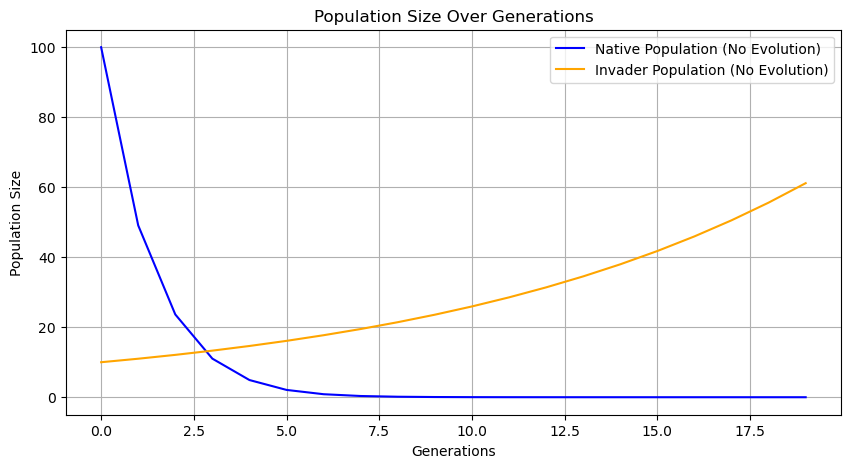

In [5]:
#plot this first run
plt.figure(figsize=(10, 5))
plt.plot(native_noevo, label='Native Population (No Evolution)', color='blue')
plt.plot(invader_noevo, label='Invader Population (No Evolution)', color='orange')
plt.title('Population Size Over Generations')
plt.xlabel('Generations')
plt.ylabel('Population Size')
plt.legend()
plt.grid()
plt.show()

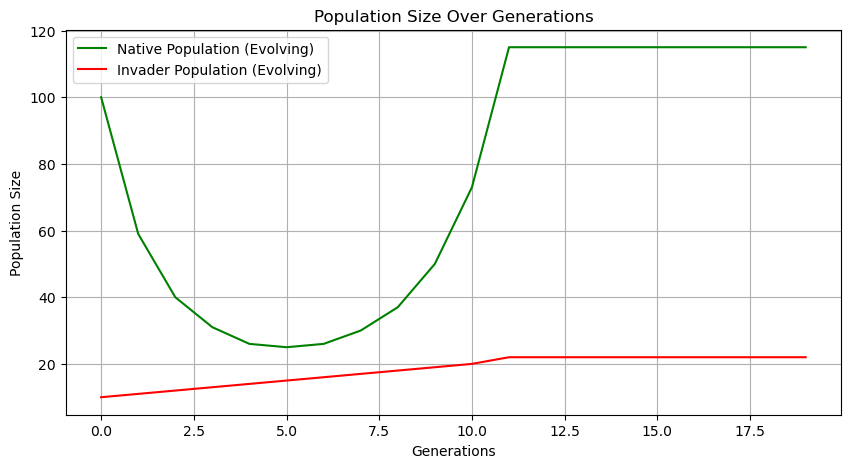

In [6]:
#plot this first run
plt.figure(figsize=(10, 5))
plt.plot(native_evo, label='Native Population (Evolving)', color='green')
plt.plot(invader_evo, label='Invader Population (Evolving)', color='red')
plt.title('Population Size Over Generations')
plt.xlabel('Generations')
plt.ylabel('Population Size')
plt.legend()
plt.grid()
plt.show()

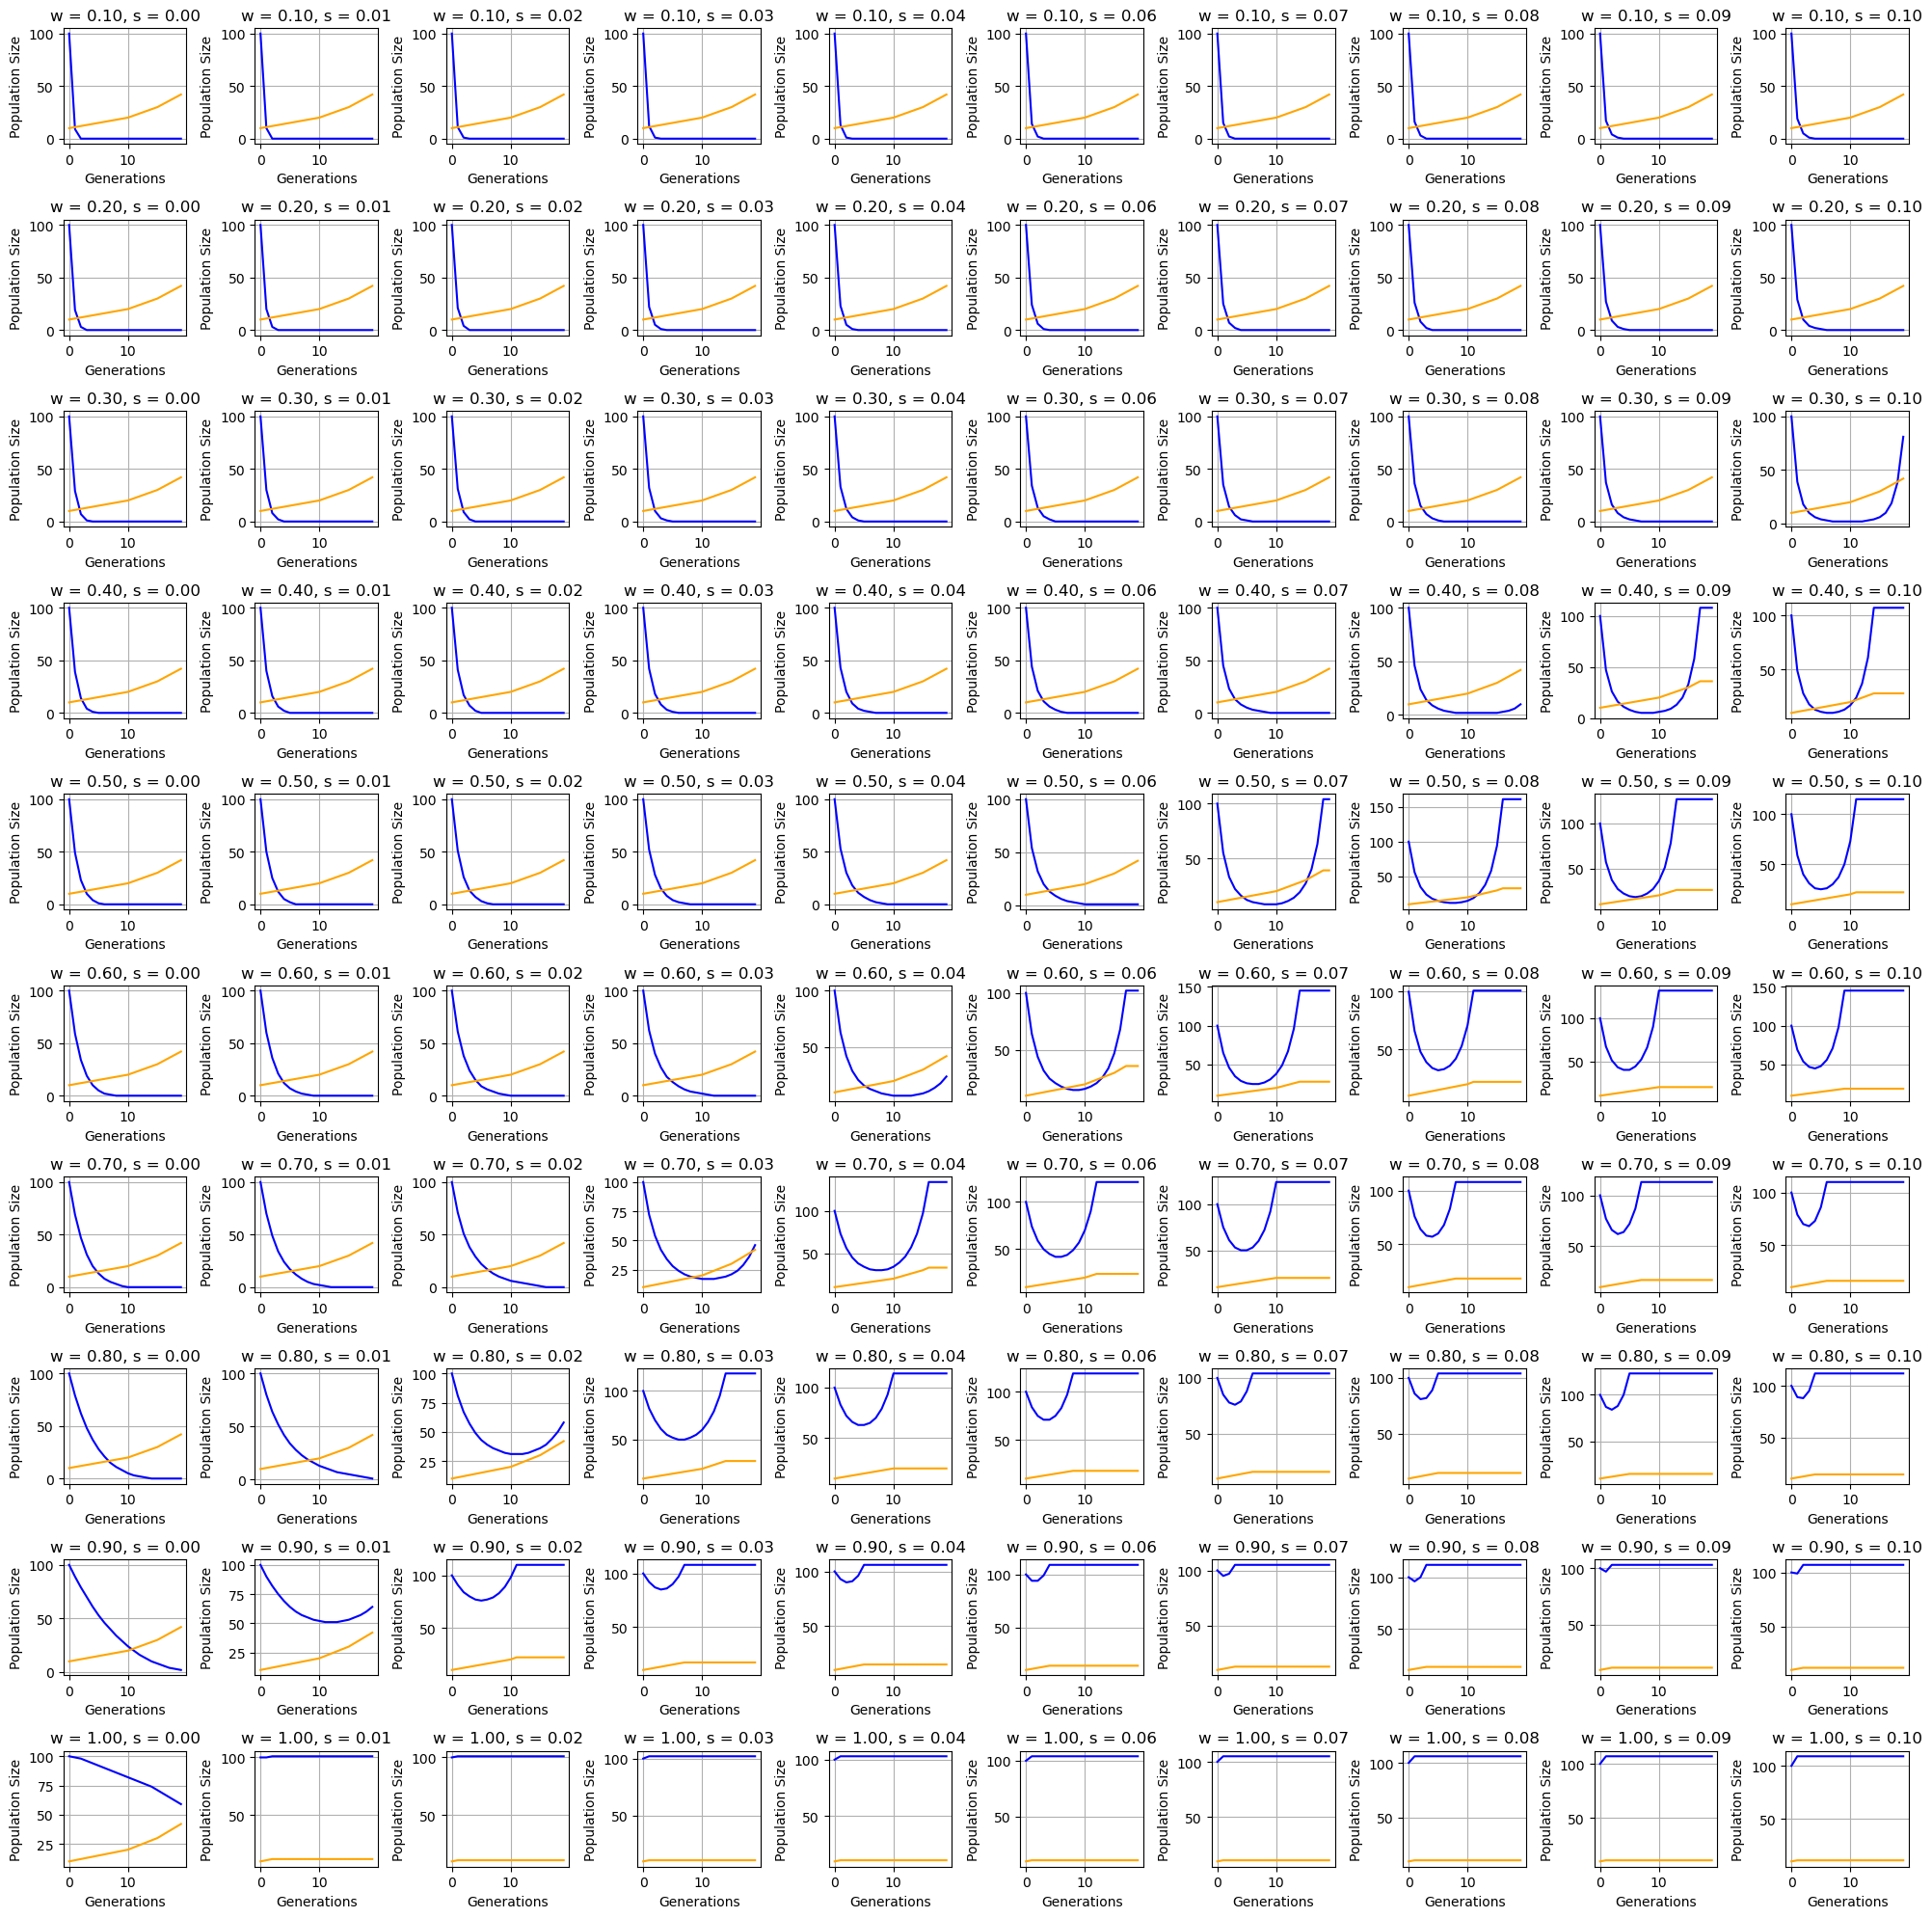

In [7]:
#try a variety of parameters
w_vals = np.linspace(0.1, 1, 10)
s_vals = np.linspace(0, 0.1, 10) #having 0 is essentially with no evolution
native_all = []
invader_all = []
for w in w_vals:
    for s in s_vals:
        native, invader = two_step_with_evolving(n_init, a_init, w, w_a, b_n, b_a, s, generations=20)
        native_all.append(native)
        invader_all.append(invader)

#plot all the runs in a grid of 10x10 subplots
fig, axs = plt.subplots(10, 10, figsize=(20, 20))
for i, (native, invader) in enumerate(zip(native_all, invader_all)):
    ax = axs[i // 10, i % 10]
    ax.plot(native, label='Native Population', color='blue')
    ax.plot(invader, label='Invader Population', color='orange')
    ax.set_title(f"w = {w_vals[i // 10]:.2f}, s = {s_vals[i % 10]:.2f}")
    ax.set_xlabel('Generations')
    ax.set_ylabel('Population Size')
    ax.grid()
plt.tight_layout()
plt.show()

In [11]:
#trying to recreate plots for period of high risk: when is the first and last time
#that the native population is below some critical threshold, like 10 individuals?

def find_critical_times(n_init, a_init, w_n, w_a, b_n, b_a, s, N_crit):
    """
    Simulate a two-step model with evolving relative fitness.
    
    Parameters:
    n_init (int): Initial population size.
    a_init (int): Initial number of invaders.
    w_n (float): Initial relative fitness of the native population.
    w_a (float): Initial relative fitness of the invader population.
    s (float): Selection coefficient (how much w_n changes each generation).
    b_n (float): Impact of the invader on the native population.
    b_a (float): Impact of the native on the invader population.
    N_crit (int): Critical population size for the native population.
    
    Returns:
    3 x int:
    - t_E: First time the native population is below N_crit.
    - t_P: Last time the native population is below N_crit.
    - risk_period: period of time between t_E and t_P, or 0 if not applicable.
    """
    
    # Initialize the population size
    n = n_init
    a = a_init
    native_sizes = []
    invader_sizes = []

    # Initialize time variables
    t_E = np.nan
    t_P = np.nan
    tE_reached = False
    tP_reached = False
    
    while not tP_reached:
        native_sizes.append(n)
        invader_sizes.append(a)

        tot = n + a
        freq_n = n / tot
        freq_a = a / tot

        w_n = w_n + s  # Update relative fitness based on selection coefficient
        n = int(n * (w_n - b_n * freq_a))  # Update population size based on relative fitness
        a = int(a * (w_a - b_a * freq_n))
        # Ensure population sizes are non-negative
        n = max(n, 0)
        a = max(a, 0)

        if n < N_crit and not tE_reached:
            t_E = len(native_sizes) - 1
            tE_reached = True
        if n > N_crit and tE_reached and not tP_reached:
            t_P = len(native_sizes) - 1
            tP_reached = True
        #if we reach above the initial population size or 0 stop
        if n > n_init:
            break
        if n <= 0:
            break

    return t_E, t_P, t_P - t_E if tP_reached else 0

s = 0.050: t_E = 4, t_P = nan, risk_period = 0
s = 0.051: t_E = 4, t_P = nan, risk_period = 0
s = 0.051: t_E = 4, t_P = nan, risk_period = 0
s = 0.052: t_E = 4, t_P = nan, risk_period = 0
s = 0.053: t_E = 4, t_P = nan, risk_period = 0
s = 0.054: t_E = 4, t_P = nan, risk_period = 0
s = 0.054: t_E = 4, t_P = 32, risk_period = 28
s = 0.055: t_E = 4, t_P = 32, risk_period = 28
s = 0.056: t_E = 4, t_P = 31, risk_period = 27
s = 0.056: t_E = 4, t_P = 31, risk_period = 27
s = 0.057: t_E = 4, t_P = 23, risk_period = 19
s = 0.058: t_E = 4, t_P = 22, risk_period = 18
s = 0.059: t_E = 4, t_P = 22, risk_period = 18
s = 0.059: t_E = 5, t_P = 19, risk_period = 14
s = 0.060: t_E = 5, t_P = 16, risk_period = 11
s = 0.061: t_E = 5, t_P = 16, risk_period = 11
s = 0.061: t_E = 5, t_P = 16, risk_period = 11
s = 0.062: t_E = 5, t_P = 16, risk_period = 11
s = 0.063: t_E = 5, t_P = 16, risk_period = 11
s = 0.064: t_E = 5, t_P = 15, risk_period = 10
s = 0.064: t_E = 5, t_P = 14, risk_period = 9
s = 0.065: t_E

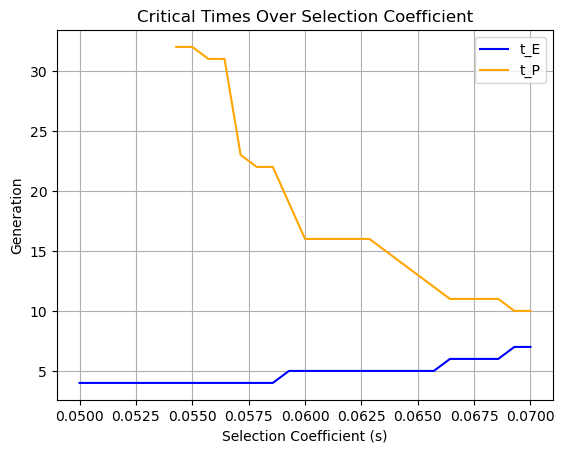

In [15]:
s_vals = np.linspace(0.05, 0.085, 50) #having 0 is essentially with no evolution
N_crit = 10
t_E_all = []
t_P_all = []
for s in s_vals:
    t_E, t_P, risk_period = find_critical_times(n_init, a_init, w_n, w_a, b_n, b_a, s, N_crit)
    t_E_all.append(t_E)
    t_P_all.append(t_P)
    print(f"s = {s:.3f}: t_E = {t_E}, t_P = {t_P}, risk_period = {risk_period}")

#plot the results
plt.plot(s_vals, t_E_all, label='t_E', color='blue')
plt.plot(s_vals, t_P_all, label='t_P', color='orange')
plt.title('Critical Times Over Selection Coefficient')
plt.xlabel('Selection Coefficient (s)')
plt.ylabel('Generation')
plt.legend()
plt.grid()
plt.show()

## Discrete-Time, Quantitative Genetic Model
In this model, essentially we have a bunch of loci that contribute to fitness; like most complex traits, this follows a normal distribution. For simplicity's sake, we ignore the loci (mutation doesn't matter, so we can do this) and focus on the resulting normally distributed phenotypes. 

When adding to the new model, we consider the following changes:
- For $W_{max}$, the invader and the native population have one; the invader has a higher one since it faces fewer threats.
- For $P$, the standard deviation of the phenotype distribution, we consider that the invader has a smaller one; since invasive species are introduced a few organisms at a time, there is less genetic diversity.
- Since $w$ and $h^2$ refer to the population as a whole, they will remain the same for both organisms. 

Furthermore, each relative fitness is adjusted according to the frequency of the other population; the invading population's fitness gets multiplies by $1 - \frac{a_t}{n_t + a_t}$ and the native population's fitness gets multiplied by $\frac{n_t}{n_t + a_t}$. In loose terms, this means that the invading population has high fitness when its frequency is low; as its frequency gets higher, the invaders start to compete with themselves. The native population does not compete with itself and so its frequency is highest when there are few invaders. 

In [37]:
#functions for model 2: discrete-time, quantitative genetic

#helper function: calculate absolute fitness
def absolute_fitness(w_max, z, w):
    return w_max * np.exp(-(z ** 2) / (2 * w))

#helper function: sample phenotypes from a normal distribution
#this has mean d_t and variance P
def sample_phenotypes(d_t, P, n):
    return np.random.normal(d_t, np.sqrt(P), n)

#helper function: calculate the absolute mean fitness
#this is the absolute fitness (above function) times the probability density of each phenotype
def absolute_mean_fitness(phenotypes, w_max, w, P):
    if len(phenotypes) == 0:
        return 0
    fitnesses = absolute_fitness(w_max, phenotypes, w)

    #get probability density of each phenotype
    probs = (1 / np.sqrt(2 * np.pi * P)) * np.exp(-(phenotypes ** 2) / (2 * P))

    #multiply fitness by probability density
    weighted_fitness = fitnesses * probs
    return np.sum(weighted_fitness) / len(phenotypes)

#helper function: change d_t
def change_dt(d_t, P, h2, w):
    return d_t + (-1 * h2 * d_t * P)/(P + w)

#now we can run the model
def quantgen_model(n_init, a_init, wn_max, wa_max, w, P_n, P_a, h2, generations=100, n_sims=1, printout=False):
    """
    Simulate a quantitative genetic model.
    
    Parameters:
    n_init (int): Initial Native population size.
    a_init (int): Initial Invader population size.
    generations (int): Number of generations to simulate.
    wn_max (float): Maximum absolute fitness for the native population.
    wa_max (float): Maximum absolute fitness for the invader population.
    w (float): Width of corresponding Gaussian function, which stays the same for both populations.
    P_n (float): Phenotypic variance for the native population.
    P_a (float): Phenotypic variance for the invader population.
    h2 (float): Heritability, which stays the same for both populations.
    n_sims (int): Number of simulations to run.
    
    Returns:
    4 x np.ndarray:
    - native_sizes: Array of native population sizes at each generation.
    - invader_sizes: Array of invader population sizes at each generation.
    - native_means: Array of native population means at each generation.
    - invader_means: Array of invader population means at each generation.
    """
    
    native_sizes = np.zeros((n_sims, generations))
    invader_sizes = np.zeros((n_sims, generations))

    for sim in range(n_sims):
        n = n_init
        a = a_init
        
        # Initialize first dt
        #d_t = np.random.normal(0, 1)
        d_tn = 1
        d_ta = 0.5 #this starts closer to 0 since the invader is naturally more fit
        for t in range(generations):
            #sample phenotypes
            native_phenos = sample_phenotypes(d_tn, P_n, n)
            invader_phenos = sample_phenotypes(d_ta, P_a, a)

            #get the current absolute mean fitness
            native_mean_fitness = absolute_mean_fitness(native_phenos, wn_max, w, P_n)
            invader_mean_fitness = absolute_mean_fitness(invader_phenos, wa_max, w, P_a)
            n = int(n * native_mean_fitness)
            a = int(a * invader_mean_fitness)

            # Ensure population sizes are non-negative
            n = max(n, 0)
            a = max(a, 0)

            # Store the population sizes
            native_sizes[sim, t] = n
            invader_sizes[sim, t] = a

            #update d_t
            d_tn = change_dt(d_tn, P_n, h2, w)
            d_ta = change_dt(d_ta, P_a, h2, w)

        if printout:
            print(f"Simulation {sim + 1} completed")

    # Calculate the mean population sizes across all simulations
    mean_native_sizes = np.mean(native_sizes, axis=0)
    mean_invader_sizes = np.mean(invader_sizes, axis=0)

    return native_sizes, invader_sizes, mean_native_sizes, mean_invader_sizes

Simulation 1 completed
Simulation 2 completed
Simulation 3 completed
Simulation 4 completed
Simulation 5 completed
Simulation 6 completed
Simulation 7 completed
Simulation 8 completed
Simulation 9 completed
Simulation 10 completed


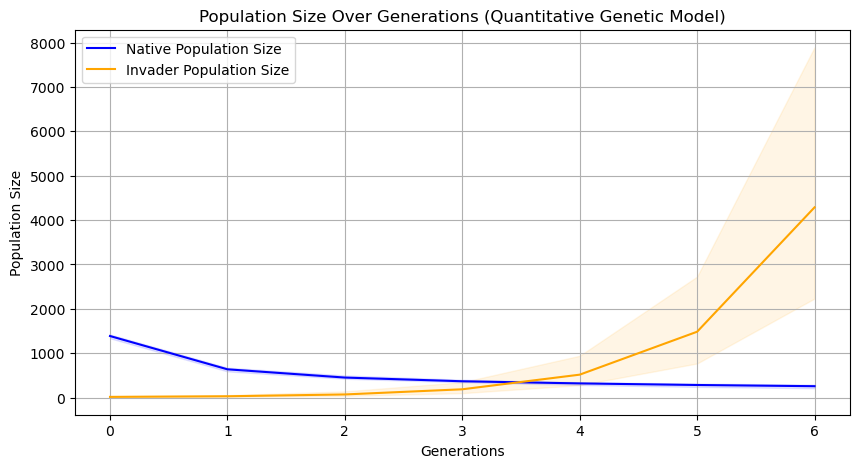

In [53]:
#run the model
n_init = 10000
a_init = 10
wn_max = 2
wa_max = 4
w = 0.1
P_n = 0.2
P_a = 0.1
h2 = 0.6
native, invader, native_mean, invader_mean = quantgen_model(n_init, a_init, wn_max, wa_max, w, P_n, P_a, h2, generations=7, n_sims=10, printout=True)

#plot the results
plt.figure(figsize=(10, 5))
plt.plot(native_mean, label='Native Population Size', color='blue')
plt.plot(invader_mean, label='Invader Population Size', color='orange')
plt.fill_between(range(len(native[0])), np.min(native, axis=0), np.max(native, axis=0), color='blue', alpha=0.1)
plt.fill_between(range(len(invader[0])), np.min(invader, axis=0), np.max(invader, axis=0), color='orange', alpha=0.1)
plt.title('Population Size Over Generations (Quantitative Genetic Model)')
plt.xlabel('Generations')
plt.ylabel('Population Size')
plt.legend()
plt.grid()
plt.show()

Note: For the above, it is important to try SMALL changes to the parameters; otherwise population will explode in size and this simulation will take decades to run and/or brick your computer. 

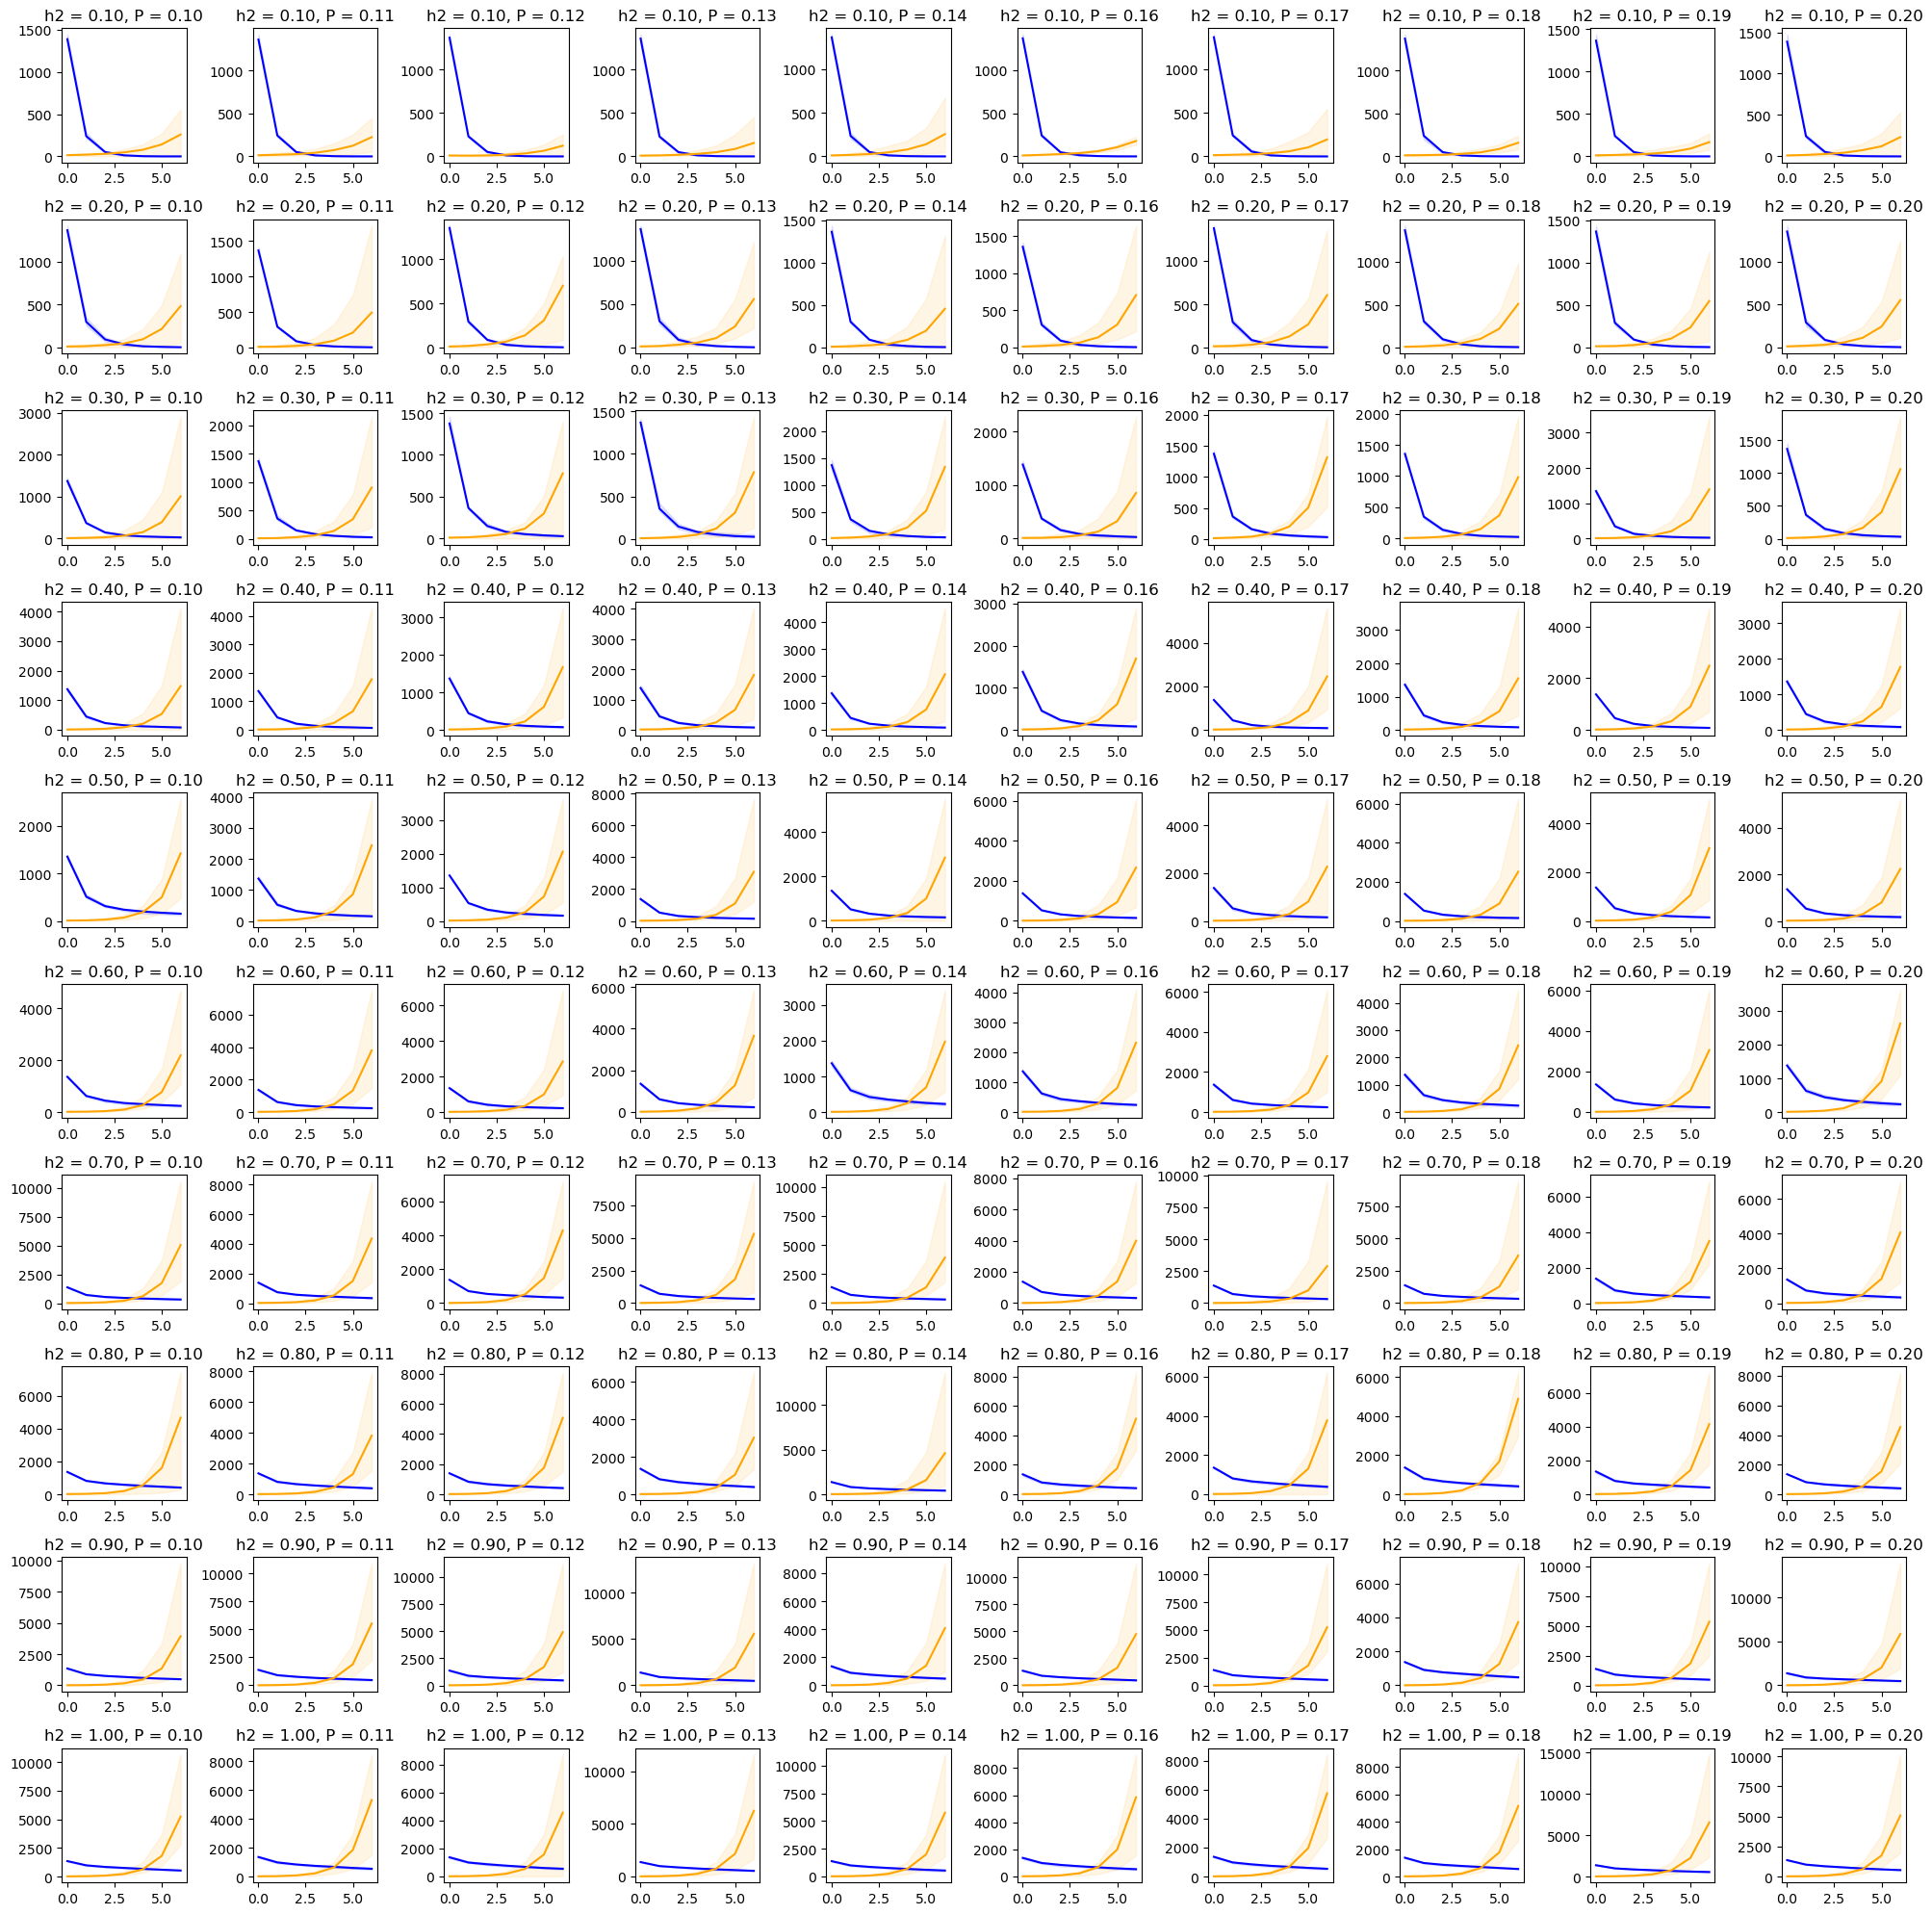

In [57]:
#same as simple two-step model, but with various values of P and h2
h2s = np.linspace(0.1, 1, 10)
Ps = np.linspace(0.1, 0.2, 10)
native_all = []
invader_all = []
mean_invaders = []
mean_natives = []
for h2 in h2s:
    for P in Ps:
        native, invader, mean_native, mean_invader = quantgen_model(n_init, a_init, wn_max, wa_max, w, P_n, P_a, h2, generations=7, n_sims=10)
        native_all.append(native)
        invader_all.append(invader)
        mean_natives.append(mean_native)
        mean_invaders.append(mean_invader)

#plot all the runs in a grid of 10x10 subplots
fig, axs = plt.subplots(10, 10, figsize=(20, 20))
for i, pops in enumerate(native_all):
    ax = axs[i // 10, i % 10]
    ax.plot(mean_natives[i], label='Native Population', color='blue')
    ax.plot(mean_invaders[i], label='Invader Population', color='orange')
    ax.fill_between(range(len(pops[0])), np.min(pops, axis=0), np.max(pops, axis=0), color='blue', alpha=0.1)
    ax.fill_between(range(len(invader_all[i][0])), np.min(invader_all[i], axis=0), np.max(invader_all[i], axis=0), color='orange', alpha=0.1)
    ax.set_title(f"h2 = {h2s[i // 10]:.2f}, P = {Ps[i % 10]:.2f}")
plt.tight_layout()
plt.show()

For the above, the authors of the paper we're following utilize $\beta_0$, initial maladaption, which is $d_0^2 / (w + P)$ and $v_0$, a proxy for initial density, that is equal to $N_c / N_0$. Please make a copy of this notebook and modify these values, so that the resulting simulations can show results. Thx.

In [ ]:
#finding critical times
#now we can run the model
def find_critical_times_quantgen(n_init, a_init, n_crit, wn_max, wa_max, w, P_n, P_a, h2, max_gens=1000, n_sims=1, printout=False):
    """
    Simulate a quantitative genetic model to find the critical time periods, where the population first enters
    and last leaves a critical period with a size below a certain threshold.
    
    Parameters:
    n_init (int): Initial Native population size.
    a_init (int): Initial Invader population size.
    n_crit (int): Critical population size for the native population.
    generations (int): Number of generations to simulate.
    wn_max (float): Maximum absolute fitness for the native population.
    wa_max (float): Maximum absolute fitness for the invader population.
    w (float): Width of corresponding Gaussian function, which stays the same for both populations.
    P_n (float): Phenotypic variance for the native population.
    P_a (float): Phenotypic variance for the invader population.
    h2 (float): Heritability, which stays the same for both populations.
    n_sims (int): Number of simulations to run.
    
    Returns:
    t_E: Average First time the native population is below n_crit.
    t_P: Average Last time the native population is below n_crit.
    risk_period: Average period of time between t_E and t_P, or 0 if not applicable.
    """

    for sim in range(n_sims):
        n = n_init
        a = a_init
        
        # Initialize first dt
        #d_t = np.random.normal(0, 1)
        d_tn = 1
        d_ta = 0.5 #this starts closer to 0 since the invader is naturally more fit
        for t in range(max_gens):
            #sample phenotypes
            native_phenos = sample_phenotypes(d_tn, P_n, n)
            invader_phenos = sample_phenotypes(d_ta, P_a, a)

            #get the current absolute mean fitness
            native_mean_fitness = absolute_mean_fitness(native_phenos, wn_max, w, P_n)
            invader_mean_fitness = absolute_mean_fitness(invader_phenos, wa_max, w, P_a)
            n = int(n * native_mean_fitness)
            a = int(a * invader_mean_fitness)

            # Ensure population sizes are non-negative
            n = max(n, 0)
            a = max(a, 0)

            #update d_t
            d_tn = change_dt(d_tn, P_n, h2, w)
            d_ta = change_dt(d_ta, P_a, h2, w)

            #check if the native population is below the critical size


        if printout:
            print(f"Simulation {sim + 1} completed")

    # Calculate the mean population sizes across all simulations
    mean_native_sizes = np.mean(native_sizes, axis=0)
    mean_invader_sizes = np.mean(invader_sizes, axis=0)

    return native_sizes, invader_sizes, mean_native_sizes, mean_invader_sizes

## Continuous-time, Diploid Single Locus Model

This is a relatively simple model and when doing this same thing for the invader, I think it may be fine to just adjust based on the frequency of the other population, as well as set the invader's w11 fitness to be higher. The w22 can be the same for both. 

In [16]:
#this one diploid locus model will take m_max, s, n_0, q_0 (initial maladaptation), generations as parameters
def diploid_locus_model(m_maxn, m_maxa, s, n_0, a_0, q_0n, q_0a, generations=100):
    """
    Simulate a diploid locus model.
    
    Parameters:
    m_maxn (float): Maximum relative fitness for the native population.
    m_maxa (float): Maximum relative fitness for the invading population.
    s (float): Difference in fitness for the maladaptive allele for the native population. From this, 
                s is calculated for the invading population.
    n_0 (int): Initial native population size.
    a_0 (int): Initial invader population size.
    q_0n (float): Initial maladaptation / frequency of the maladaptive allele for the native population.
    q_0a (float): Initial maladaptation / frequency of the maladaptive allele for the invading population.
    generations (int): Number of generations to simulate.
    
    Returns:
    np.ndarray: Array of population sizes at each generation.
    """

    #check: is s > m_max? if not, return an error
    if s < m_maxn:
        raise ValueError("Selection coefficient s must be greater than or equal to maximum mutation rate m_max.")
    
    # Initialize the population size
    n = n_0
    a = a_0

    qn = q_0n
    pn = 1 - qn  # Frequency of the beneficial allele
    qa = q_0a
    pa = 1 - qa  # Frequency of the beneficial allele

    #initialize relative fitnesses
    m11_n = m_maxn
    m12_n = m_maxn - (s/2)
    m22_n = m_maxn - s

    m11_a = m_maxa
    m12_a = (m_maxa + m22_n) / 2
    m22_a = m22_n

    # Initialize the population size array
    native_sizes = np.zeros(generations)
    invader_sizes = np.zeros(generations)

    #initialize number of p2, pq, and q2
    num_np2 = n * (pn ** 2)
    num_npq = n * (2 * pn * qn)
    num_nq2 = n * (qn ** 2)

    num_ap2 = a * (pa ** 2)
    num_apq = a * (2 * pa * qa)
    num_aq2 = a * (qa ** 2)
    
    for t in range(generations):
        native_sizes[t] = n
        invader_sizes[t] = a

        freq_n = n / (n + a)
        freq_a = a / (n + a)

        m_nt = m11_n * (pn ** 2) + m12_n * (2 * pn * qn) + m22_n * (qn ** 2)
        n_next = n * m_nt * freq_n + n
        a_nt = m11_a * (pa ** 2) + m12_a * (2 * pa * qa) + m22_a * (qa ** 2)
        a_next = a * a_nt * (1 - freq_a) + a

        # Calculate the next generation frequencies
        np2_next = (num_np2 * m11_n * freq_n) + num_np2
        npq_next = (num_npq * m12_n * freq_n) + num_npq
        nq2_next = (num_nq2 * m22_n * freq_n)  + num_nq2

        ap2_next = (num_ap2 * m11_a * (1-freq_a)) + num_ap2
        apq_next = (num_apq * m12_a * (1-freq_a)) + num_apq
        aq2_next = (num_aq2 * m22_a * (1-freq_a)) + num_aq2

        pn_next = np2_next / n_next
        qn_next = 1 - pn_next
        pa_next = ap2_next / a_next
        qa_next = 1 - pa_next

        # Update the population size and allele frequencies
        n = n_next
        a = a_next
        pn = pn_next
        qn = qn_next
        pa = pa_next
        qa = qa_next

        # Update the number of p2, pq, and q2
        num_np2 = np2_next
        num_npq = npq_next
        num_nq2 = nq2_next

        num_ap2 = ap2_next
        num_apq = apq_next
        num_aq2 = aq2_next

        #if n_next = 0, fill the rest of the generations with 0 and stop
        if n_next <= 0:
            native_sizes[t:] = 0
            invader_sizes[t:] = a
            break
    
    return native_sizes, invader_sizes

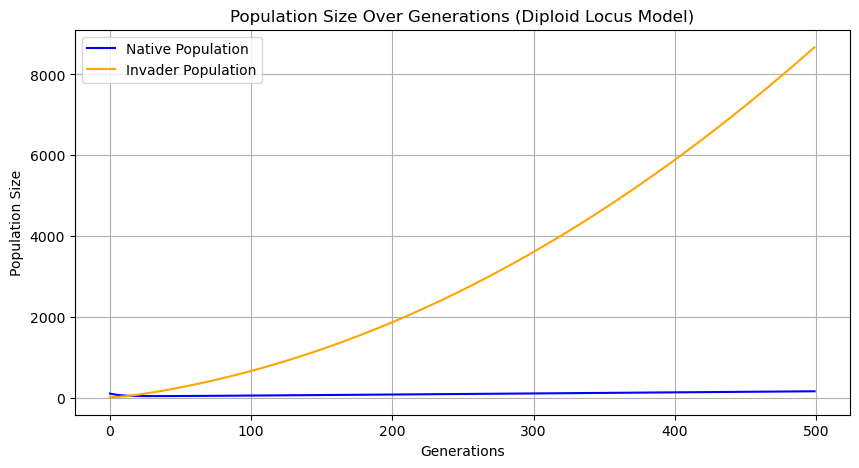

In [17]:
m_maxn = 0.1
m_maxa = 0.2
s = 0.2
n_0 = 100
a_0 = 10
q_0n = 0.8
q_0a = 0.2
native_pop, invader_pop = diploid_locus_model(m_maxn, m_maxa, s, n_0, a_0, q_0n, q_0a, generations=500)

#plot the results
plt.figure(figsize=(10, 5))
plt.plot(native_pop, color='blue', label='Native Population')
plt.plot(invader_pop, color='orange', label='Invader Population')
plt.title('Population Size Over Generations (Diploid Locus Model)')
plt.xlabel('Generations')
plt.ylabel('Population Size')
plt.grid()
plt.legend()
plt.show()

The paper we're basing this from doesn't add much but they do look at the time spent at the critical density/critical amount as a function of the initial $q_0$ and as a function of the initial density $v_0$ so those would be things to look at in the adaptations.

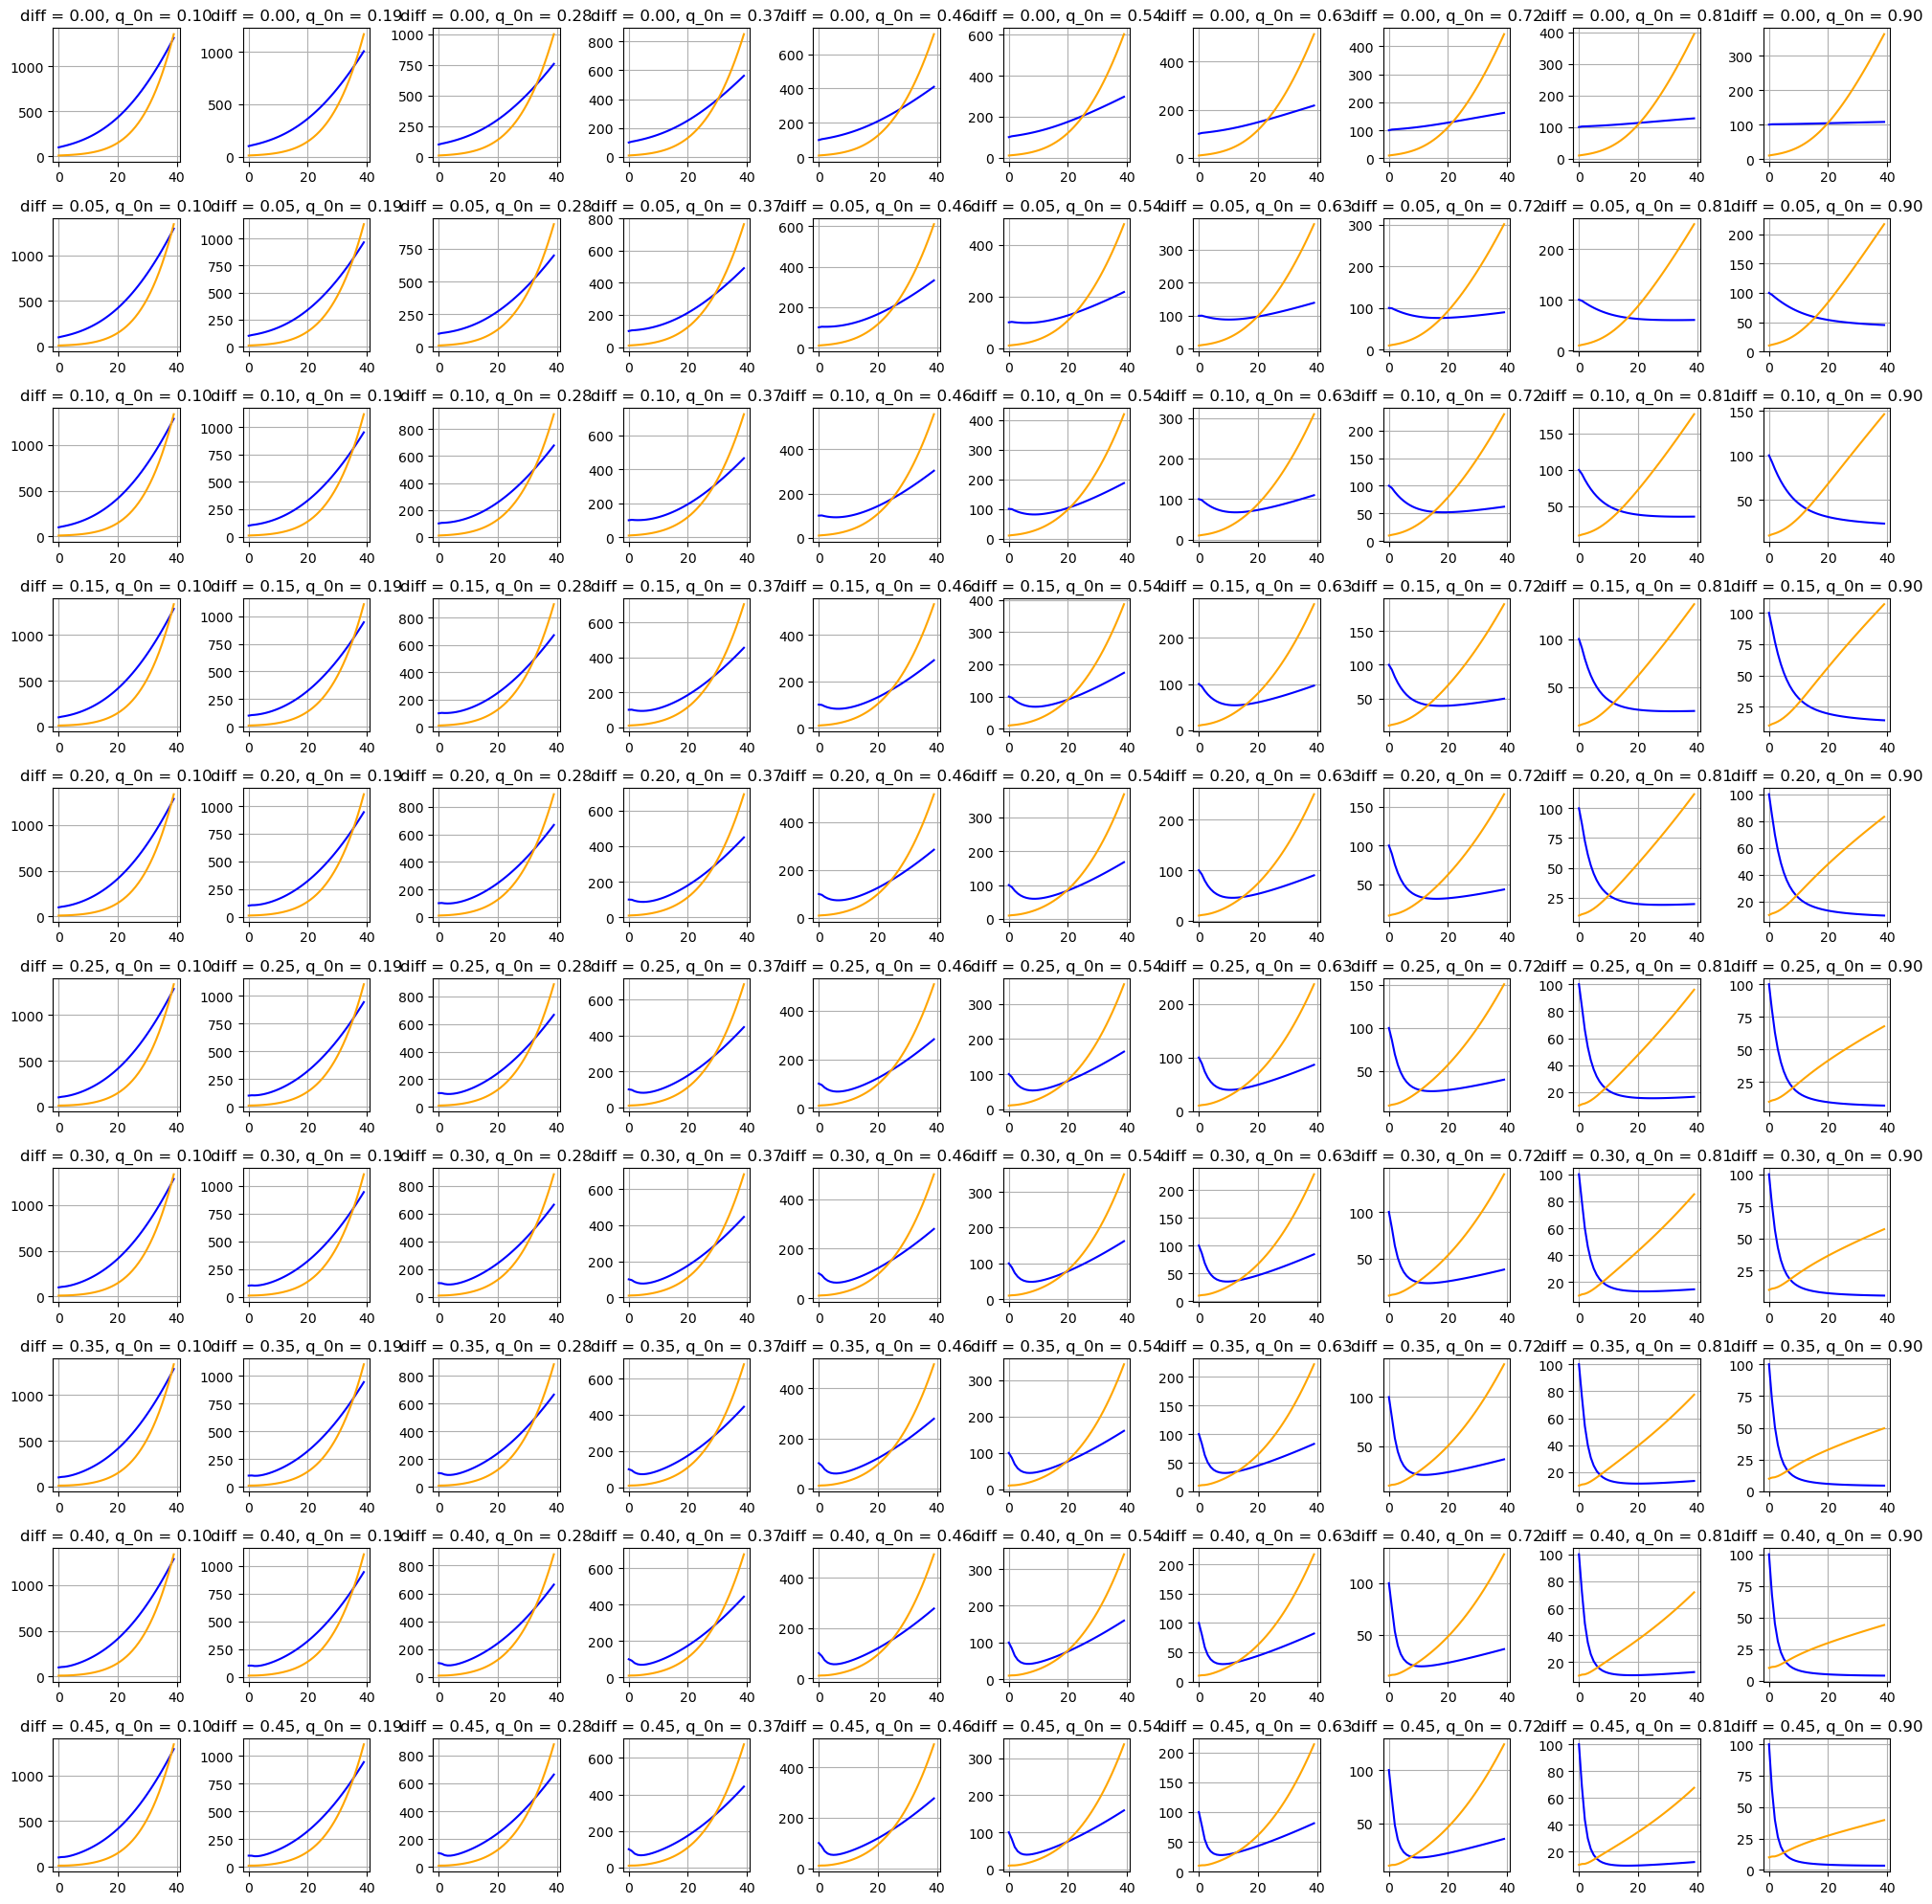

In [18]:
#same as prior multiplots but for various q_0, and difference between s and m_max
m_maxn = 0.1
diffs = np.linspace(0, 0.45, 10)
q_0ns = np.linspace(0.1, 0.9, 10)
native_pops_all = []
invader_pops_all = []

for diff in diffs:
    for q_0n in q_0ns:
        s = m_maxn + diff
        native, invader = diploid_locus_model(m_maxn, m_maxa, s, n_0, a_0, q_0n, q_0a, generations=40)
        native_pops_all.append(native)
        invader_pops_all.append(invader)

#plot all the runs in a grid of 10x10 subplots
fig, axs = plt.subplots(10, 10, figsize=(20, 20))
for i in range(len(native_pops_all)):
    ax = axs[i // 10, i % 10]
    ax.plot(native_pops_all[i], color='blue', label='Native Population')
    ax.plot(invader_pops_all[i], color='orange', label='Invader Population')
    ax.set_title(f"diff = {diffs[i // 10]:.2f}, q_0n = {q_0ns[i % 10]:.2f}")
    ax.grid()
plt.tight_layout()
plt.show()


In [23]:
#finding critical times for the diploid locus model
#this one diploid locus model will take m_max, s, n_0, q_0 (initial maladaptation), generations as parameters
def find_critical_times_diploid(m_maxn, m_maxa, s, n_0, a_0, q_0n, q_0a, N_crit, stopping_gen = 10000):
    """
    Simulate a diploid locus model.
    
    Parameters:
    m_maxn (float): Maximum relative fitness for the native population.
    m_maxa (float): Maximum relative fitness for the invading population.
    s (float): Difference in fitness for the maladaptive allele for the native population. From this, 
                s is calculated for the invading population.
    n_0 (int): Initial native population size.
    a_0 (int): Initial invader population size.
    q_0n (float): Initial maladaptation / frequency of the maladaptive allele for the native population.
    q_0a (float): Initial maladaptation / frequency of the maladaptive allele for the invading population.
    N_crit (int): Critical population size for the native population.
    
    Returns:
    t_E (int): First time the native population is below N_crit.
    t_P (int): Last time the native population is below N_crit.
    """

    #check: is s > m_max? if not, return an error
    if s < m_maxn:
        raise ValueError("Selection coefficient s must be greater than or equal to maximum mutation rate m_max.")
    
    # Initialize the population size
    n = n_0
    a = a_0

    qn = q_0n
    pn = 1 - qn  # Frequency of the beneficial allele
    qa = q_0a
    pa = 1 - qa  # Frequency of the beneficial allele

    #initialize relative fitnesses
    m11_n = m_maxn
    m12_n = m_maxn - (s/2)
    m22_n = m_maxn - s

    m11_a = m_maxa
    m12_a = (m_maxa + m22_n) / 2
    m22_a = m22_n

    # Initialize the population size array
    native_sizes = []
    invader_sizes = []

    #initialize number of p2, pq, and q2
    num_np2 = n * (pn ** 2)
    num_npq = n * (2 * pn * qn)
    num_nq2 = n * (qn ** 2)

    num_ap2 = a * (pa ** 2)
    num_apq = a * (2 * pa * qa)
    num_aq2 = a * (qa ** 2)

    t_E = np.nan
    t_P = np.nan
    tE_reached = False
    tP_reached = False
    
    while not tP_reached:
        native_sizes.append(n)
        invader_sizes.append(a)

        freq_n = n / (n + a)
        freq_a = a / (n + a)

        m_nt = m11_n * (pn ** 2) + m12_n * (2 * pn * qn) + m22_n * (qn ** 2)
        n_next = n * m_nt * freq_n + n
        a_nt = m11_a * (pa ** 2) + m12_a * (2 * pa * qa) + m22_a * (qa ** 2)
        a_next = a * a_nt * (1 - freq_a) + a

        # Calculate the next generation frequencies
        np2_next = (num_np2 * m11_n * freq_n) + num_np2
        npq_next = (num_npq * m12_n * freq_n) + num_npq
        nq2_next = (num_nq2 * m22_n * freq_n)  + num_nq2

        ap2_next = (num_ap2 * m11_a * (1-freq_a)) + num_ap2
        apq_next = (num_apq * m12_a * (1-freq_a)) + num_apq
        aq2_next = (num_aq2 * m22_a * (1-freq_a)) + num_aq2

        pn_next = np2_next / n_next
        qn_next = 1 - pn_next
        pa_next = ap2_next / a_next
        qa_next = 1 - pa_next

        # Update the population size and allele frequencies
        n = n_next
        a = a_next
        pn = pn_next
        qn = qn_next
        pa = pa_next
        qa = qa_next

        # Update the number of p2, pq, and q2
        num_np2 = np2_next
        num_npq = npq_next
        num_nq2 = nq2_next

        num_ap2 = ap2_next
        num_apq = apq_next
        num_aq2 = aq2_next

        if n < N_crit and not tE_reached:
            t_E = len(native_sizes) - 1
            tE_reached = True
        if n > N_crit and tE_reached and not tP_reached:
            t_P = len(native_sizes) - 1
            tP_reached = True
        if n > n_0:
            break
        if n == 0:
            break
        if len(native_sizes) >= stopping_gen: #so we don't get explosive values
            t_P = len(native_sizes) - 1
            tP_reached = True
            break
    
    return t_E, t_P, t_P - t_E if tP_reached else 0

qn = 0.800, qa = 0.200: t_E = 10, t_P = 95, risk_period = 85
qn = 0.804, qa = 0.196: t_E = 10, t_P = 105, risk_period = 95
qn = 0.808, qa = 0.192: t_E = 10, t_P = 117, risk_period = 107
qn = 0.812, qa = 0.188: t_E = 10, t_P = 130, risk_period = 120
qn = 0.816, qa = 0.184: t_E = 10, t_P = 144, risk_period = 134
qn = 0.820, qa = 0.180: t_E = 10, t_P = 161, risk_period = 151
qn = 0.824, qa = 0.176: t_E = 10, t_P = 180, risk_period = 170
qn = 0.829, qa = 0.171: t_E = 9, t_P = 202, risk_period = 193
qn = 0.833, qa = 0.167: t_E = 9, t_P = 227, risk_period = 218
qn = 0.837, qa = 0.163: t_E = 9, t_P = 257, risk_period = 248
qn = 0.841, qa = 0.159: t_E = 9, t_P = 290, risk_period = 281
qn = 0.845, qa = 0.155: t_E = 9, t_P = 329, risk_period = 320
qn = 0.849, qa = 0.151: t_E = 9, t_P = 375, risk_period = 366
qn = 0.853, qa = 0.147: t_E = 9, t_P = 428, risk_period = 419
qn = 0.857, qa = 0.143: t_E = 9, t_P = 491, risk_period = 482
qn = 0.861, qa = 0.139: t_E = 9, t_P = 564, risk_period = 555
qn =

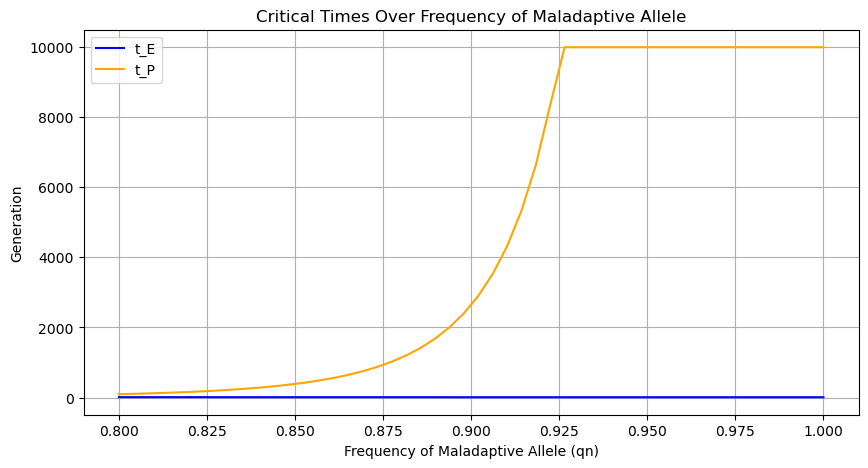

In [24]:
qn_vals = np.linspace(0.8, 1, 50)
qa_vals = 1 - qn_vals

m_maxn = 0.1
m_maxa = 0.2
s = 0.2
n_0 = 20
a_0 = 2
N_crit = 10

t_E_all = []
t_P_all = []

for qn, qa in zip(qn_vals, qa_vals):
    t_E, t_P, risk_period = find_critical_times_diploid(m_maxn, m_maxa, s, n_0, a_0, qn, qa, N_crit)
    t_E_all.append(t_E)
    t_P_all.append(t_P)
    print(f"qn = {qn:.3f}, qa = {qa:.3f}: t_E = {t_E}, t_P = {t_P}, risk_period = {risk_period}")

#plot the results
plt.figure(figsize=(10, 5))
plt.plot(qn_vals, t_E_all, label='t_E', color='blue')
plt.plot(qn_vals, t_P_all, label='t_P', color='orange')
plt.title('Critical Times Over Frequency of Maladaptive Allele')
plt.xlabel('Frequency of Maladaptive Allele (qn)')
plt.ylabel('Generation')
plt.legend()
plt.grid()
plt.show()


n_0 = 10.000: t_E = 0, t_P = 551, risk_period = 551
n_0 = 10.408: t_E = 0, t_P = 502, risk_period = 502
n_0 = 10.816: t_E = 1, t_P = 459, risk_period = 458
n_0 = 11.224: t_E = 1, t_P = 420, risk_period = 419
n_0 = 11.633: t_E = 2, t_P = 386, risk_period = 384
n_0 = 12.041: t_E = 2, t_P = 355, risk_period = 353
n_0 = 12.449: t_E = 3, t_P = 328, risk_period = 325
n_0 = 12.857: t_E = 3, t_P = 303, risk_period = 300
n_0 = 13.265: t_E = 3, t_P = 281, risk_period = 278
n_0 = 13.673: t_E = 4, t_P = 260, risk_period = 256
n_0 = 14.082: t_E = 4, t_P = 242, risk_period = 238
n_0 = 14.490: t_E = 5, t_P = 225, risk_period = 220
n_0 = 14.898: t_E = 5, t_P = 210, risk_period = 205
n_0 = 15.306: t_E = 6, t_P = 196, risk_period = 190
n_0 = 15.714: t_E = 6, t_P = 183, risk_period = 177
n_0 = 16.122: t_E = 6, t_P = 172, risk_period = 166
n_0 = 16.531: t_E = 7, t_P = 161, risk_period = 154
n_0 = 16.939: t_E = 7, t_P = 151, risk_period = 144
n_0 = 17.347: t_E = 7, t_P = 142, risk_period = 135
n_0 = 17.755

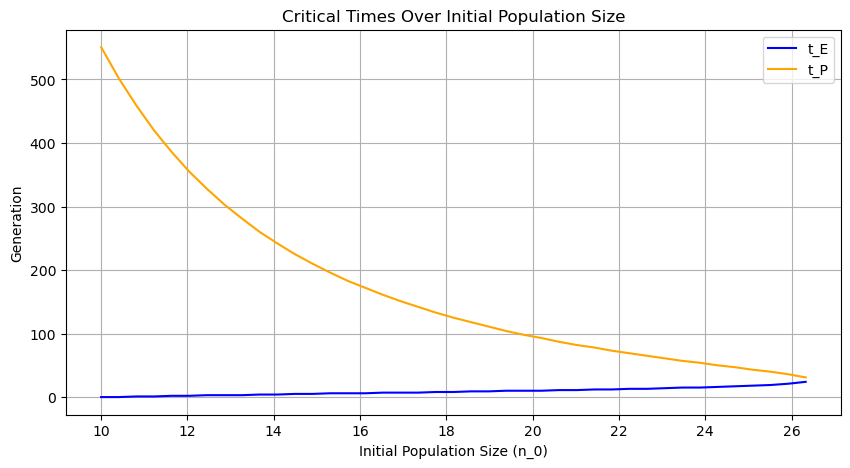

In [26]:
n_0_vals = np.linspace(10, 30, 50)

m_maxn = 0.1
m_maxa = 0.2
s = 0.2
a_0 = 2
q_0n = 0.8
q_0a = 0.2
N_crit = 10

t_E_all = []
t_P_all = []
for n_0 in n_0_vals:
    t_E, t_P, risk_period = find_critical_times_diploid(m_maxn, m_maxa, s, n_0, a_0, q_0n, q_0a, N_crit)
    t_E_all.append(t_E)
    t_P_all.append(t_P)
    print(f"n_0 = {n_0:.3f}: t_E = {t_E}, t_P = {t_P}, risk_period = {risk_period}")

#plot the results
plt.figure(figsize=(10, 5))
plt.plot(n_0_vals, t_E_all, label='t_E', color='blue')
plt.plot(n_0_vals, t_P_all, label='t_P', color='orange')
plt.title('Critical Times Over Initial Population Size')
plt.xlabel('Initial Population Size (n_0)')
plt.ylabel('Generation')
plt.legend()
plt.grid()
plt.show()